In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm
import itertools
from collections import defaultdict 
import numpy as np
from snpp.utils.matrix import load_sparse_csr, \
    split_train_test
from snpp.utils.signed_graph import matrix2graph


dataset = 'slashdot'
raw_mat_path = 'data/{}.npz'.format(dataset)
random_seed = 123456

In [3]:
m = load_sparse_csr(raw_mat_path)

print('split_train_test')
train_m, test_m = split_train_test(
    m,
    weights=[0.9, 0.1])

test_entries = set(tuple(sorted((i, j)))
                   for i, j in zip(*test_m.nonzero()))
g = matrix2graph(m, None)

split_train_test


988it [00:00, 4067.39it/s]

building MultiGraph


516575it [02:38, 3249.78it/s]


In [4]:
# getting all triangles
nodes_nbrs = g.adj.items()

triangles = set()
for v, v_nbrs in tqdm(nodes_nbrs):
    vs = set(v_nbrs) - set([v])
    ntriangles = 0
    for w in vs:
        ws = set(g[w]) - set([w])
        for u in vs.intersection(ws):
            triangles.add(tuple(sorted([u, v, w])))
        
print("{} triangles".format(len(triangles)))

100%|██████████| 77350/77350 [01:05<00:00, 1188.74it/s] 

548054 triangles


In [5]:
triangle_order_cnt = np.zeros(4)
for t in tqdm(triangles):
    its = filter(lambda e: tuple(sorted(e)) in test_entries,
                 itertools.combinations(t, 2))
    triangle_order_cnt[len(list(its))] += 1

print('the percetange of 0, 1, 2, 3-order triangles:')
print(triangle_order_cnt / np.sum(triangle_order_cnt) * 100)

100%|██████████| 548054/548054 [00:10<00:00, 52945.72it/s]

the percetange of 0, 1, 2, 3-order triangles:
[ 65.74644104  29.37940422   4.63312009   0.24103464]


In [7]:
edge2triangle_order = defaultdict(lambda: np.zeros(4))
for t in tqdm(triangles):
    edges = list(filter(lambda e: tuple(sorted(e)) in test_entries,
                       itertools.combinations(t, 2)))
    for e in edges:
       edge2triangle_order[e][len(edges)] += 1
    
m = np.array(list(edge2triangle_order.values()))
print(m.shape)

print('mean of triangle order count on edges: {}'.format(np.mean(m, axis=0)))
print('median of triangle order count on edges: {}'.format(np.median(m, axis=0)))
print('std of triangle order count on edges: {}'.format(np.std(m, axis=0)))
print('max of triangle order count on edges: {}'.format(np.max(m, axis=0)))
print('min of triangle order count on edges: {}'.format(np.min(m, axis=0)))
                                                                 


100%|██████████| 548054/548054 [00:03<00:00, 140581.56it/s]

(26682, 4)
mean of triangle order count on edges: [ 0.          6.03459261  1.9033056   0.1485271 ]
median of triangle order count on edges: [ 0.  2.  1.  0.]
std of triangle order count on edges: [  0.          11.72956756   4.48512574   0.5433183 ]
max of triangle order count on edges: [   0.  242.   63.    9.]
min of triangle order count on edges: [ 0.  0.  0.  0.]


In [26]:
print('triangle count mean: {}'.format(np.mean(m.sum(axis=1))))
print('triangle count median: {}'.format(np.median(m.sum(axis=1))))
print('triangle count max: {}'.format(np.max(m.sum(axis=1))))

triangle count mean: 8.086425305449367
triangle count median: 3.0
triangle count max: 307.0


In [16]:
print("#edges with at least 1 triangles: {}".format(m.shape[0]))
print("#edges without any triangles: {}".format(len(test_entries) - m.shape[0]))

#edges with at least 1 triangles: 26682
#edges without any triangles: 24489


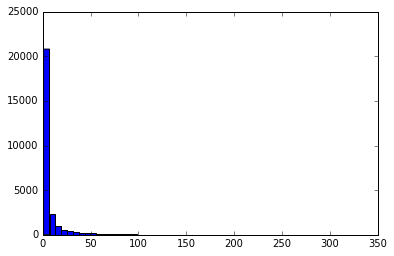

In [31]:
triangle_counts = m.sum(axis=1)
plt.hist(triangle_counts, 50)
plt.show()

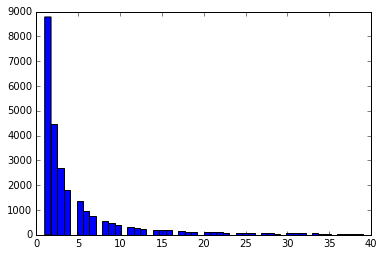

In [30]:
plt.hist(triangle_counts[triangle_counts < 40], 50)
plt.show()